# Emerge enables microenvironment-aware imputation of unmeasured genes in MOp

In [1]:
import pandas as pd
import numpy  as np
import anndata
import scanpy as sc
from emerge import run_emerge
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

Read spatial dataset and scRNA-seq dataset. Datasets can be downloaded from **Zenodo**:  
[10.5281/zenodo.17214560](https://doi.org/10.5281/zenodo.17214560).

In [2]:
#exp
fish_exp_raw = pd.read_csv('data/spatial/m2s2s300.csv',header=0,index_col=0,sep=',')
#type
fish_type = pd.read_csv('data/spatial/m2s300_label.csv',header=0,index_col=0,sep=',')
fish_type.set_index('cell_ID', inplace=True)
#loc
fish_loc = pd.read_csv('data/spatial/m2s300_loc.csv',header=0,index_col=0,sep=',')

In [3]:
scrna_sc_raw = pd.read_csv('data/scrna/nucsmart/exon.counts.csv',header=0,index_col=0,sep=',')
qcell = pd.read_csv('data/scrna/nucsmart/QC.csv')
scrna_sc_raw = scrna_sc_raw.loc[:,qcell['x']]
scrna_sc_raw = scrna_sc_raw.T
#type
scrna_type_raw = pd.read_csv('data/scrna/nucsmart/cluster.membership.csv',header=0,index_col=0,sep=',')
scrna_type_raw = scrna_type_raw.loc[scrna_sc_raw.index,:]
scrna_type_raw.insert(loc=len(scrna_type_raw.columns), column='Annotation', value=None)
scrna_type_raw.insert(loc=len(scrna_type_raw.columns), column='Annotation2', value=None)
scrna_anno = pd.read_csv('data/scrna/nucsmart/cluster.annotation.csv',header=0,index_col=0,sep=',')
for i in np.unique(scrna_type_raw['x'].values):
    scrna_type_raw.loc[scrna_type_raw['x'] == i, 'Annotation'] = scrna_anno.loc[scrna_anno.index==i,'subclass_label'].values[0]

Use spatial and scRNA-seq common genes as training genes, use unique genes in the scRNA-seq as predict genes. 

In [4]:
common_gene = list(set(scrna_sc_raw.columns) & set(fish_exp_raw.columns))
common_gene = sorted(common_gene)

pre_gene = np.setdiff1d(scrna_sc_raw.columns, common_gene)

Use Emerge-cluster to predict unmeasured gene expression, please ensure that the argument `fish_type` is specified when calling the function.

In [5]:
re_list = run_emerge(
    fish_exp_raw = fish_exp_raw,
    fish_type = fish_type,
    fish_loc=fish_loc,            
    scrna_sc_raw = scrna_sc_raw,       
    scrna_type_raw=scrna_type_raw,        
    x_col = "X", 
    y_col = "Y",
    layeruse= "Annotation",
    train_genes=common_gene,
    test_genes=pre_gene,
    cell_or_cluster = "cluster",     # "cell" "cluster"
    env_backend= "standard",     # "standard"=envpca "big"=envpcabignome for big data  
) 

(343, 12)
(451, 15)
(470, 11)
(163, 11)
(855, 14)
(54, 12)
(458, 10)
(191, 10)
(54, 8)
(29, 13)
(86, 14)
(79, 13)
(290, 11)
(99, 14)
(2, 6)
(34, 14)
(42, 11)
(343, 16)
(451, 16)
(470, 12)
(163, 14)
(855, 15)
(54, 14)
(458, 15)
(191, 13)
(54, 10)
(29, 17)
(86, 16)
(79, 16)
(290, 15)
(99, 15)
(2, 10)
(34, 15)
(42, 14)
(343, 16)
(451, 16)
(470, 12)
(163, 14)
(855, 15)
(54, 14)
(458, 15)
(191, 15)
(54, 11)
(29, 17)
(86, 16)
(79, 17)
(290, 16)
(99, 15)
(2, 11)
(34, 15)
(42, 16)
(343, 17)
(451, 17)
(470, 12)
(163, 15)
(855, 15)
(54, 15)
(458, 15)
(191, 15)
(54, 13)
(29, 17)
(86, 17)
(79, 17)
(290, 16)
(99, 16)
(2, 11)
(34, 16)
(42, 16)
(343, 17)
(451, 17)
(470, 14)
(163, 15)
(855, 15)
(54, 15)
(458, 15)
(191, 15)
(54, 13)
(29, 17)
(86, 17)
(79, 17)
(290, 16)
(99, 16)
(2, 11)
(34, 16)
(42, 16)
Astro
Endo
L2/3 IT
L5 ET
L5 IT
L5/6 NP
L6 CT
L6 IT
L6b
Lamp5
Micro
OPC
Oligo
Pvalb
Sncg
Sst
Vip
497


The predicted gene expression matrix can be found in the result list under **`pre_sc_test`**.

In [6]:
pre_sc_test_a1ori = re_list['pre_sc_test']
pre_sc_test_a1 =  pre_sc_test_a1ori.copy()
pre_sc_test_a1 = anndata.AnnData(pre_sc_test_a1)
#type
fish_type.index = pre_sc_test_a1.to_df().index
#loc
fish_loc.index = fish_type.index
fish_loc_val = fish_loc[['X','Y']].values

pre_sc_test_a1.obs['cell_type'] = fish_type['cell_types'].values

Gene expression pattern visualization.

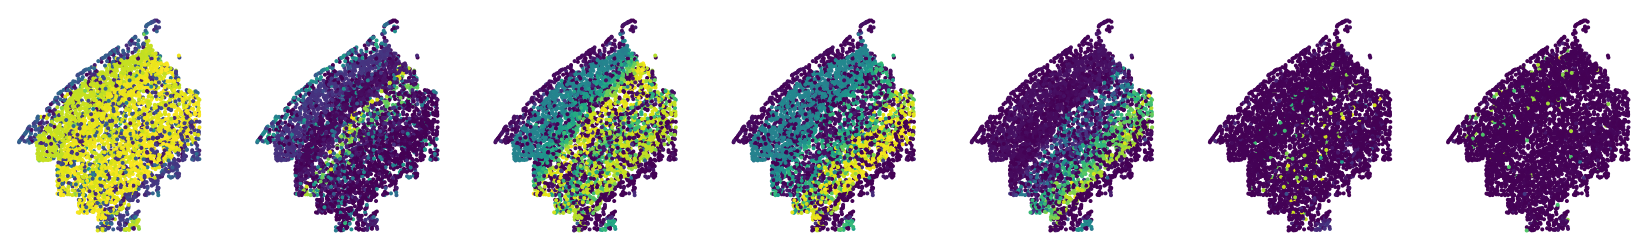

In [7]:
sdgelist = [pre_sc_test_a1.to_df().T.values]
gene_names =pre_sc_test_a1.to_df().columns
genes = ['Snap25','Bcl6','Pde1a','Nptx1','Col6a1','Tac1','Adarb2']
plt.figure(figsize=(21,3))
idx=1
for sdge in sdgelist:
    for gene in genes:        
        plt.subplot(len(sdgelist), len(genes), idx)
        plt.scatter(fish_loc_val[:, 0], fish_loc_val[:, 1], 
                            c=sdge[np.argwhere(gene_names == gene), :].flatten(),
                            s=3.5, cmap='viridis')
        plt.axis('off')
        plt.gca().invert_yaxis()
        idx += 1
plt.savefig('unmea_gene.png', dpi=600)
plt.show()

Concate spatially measured data and predicted data.

In [13]:
pre_sc_test_a1ori = anndata.AnnData(pre_sc_test_a1ori)
fish_exp_raw.index =pre_sc_test_a1ori.to_df().index.values
fish_raw = anndata.AnnData(fish_exp_raw)
sc.pp.normalize_total(fish_raw)
sc.pp.log1p(fish_raw)
adataall = sc.concat([fish_raw, pre_sc_test_a1ori], join='outer', axis=1)
fish_type.index = adataall.to_df().index
fish_loc.index = adataall.to_df().index
fish_loc_val = fish_loc[['X','Y']].values
adataall.obs['cell_types'] = fish_type['cell_types'].values
adataall.X = np.exp(adataall.X)-1
sc.pp.normalize_per_cell(adataall)
sc.pp.log1p(adataall)
keep_cells = adataall.obs['cell_types'] != 'Sncg'
adataall = adataall[keep_cells, :].copy()
fish_loc_valkeep = fish_loc_val[keep_cells.values,]

Environmental features can be found in the result list under **`eva_type_use_list_cross`**.

In [14]:
eva_type_use_list_crossu = re_list['eva_type_use_list_cross'][0]
merged_df = pd.concat(eva_type_use_list_crossu, axis=0, join='outer').fillna(0)#[3389 rows x 17 columns]

### Microenvironment-aware spatial analysis of Astro

In [15]:
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram,fcluster

type_plot = 'Astro' 
exp_use_Astro = adataall.to_df().loc[fish_type.index.values[fish_type['cell_types'] == type_plot],:].copy()
df = merged_df.copy()
df = df.loc[np.intersect1d(merged_df.index.values, exp_use_Astro.index.values),]
fish_type_plot = fish_type.loc[exp_use_Astro.index.values,:]
fish_locru = fish_loc.loc[exp_use_Astro.index.values,:]
df.drop(columns=['Sncg'], inplace=True)
expeno = df
expeno = anndata.AnnData(expeno) 

Identification of Niches.

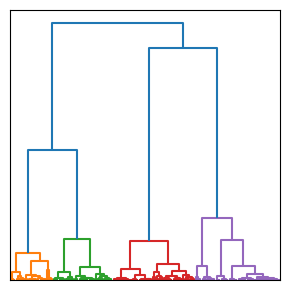

In [17]:
expenodf = expeno.to_df()
gene_expression = expenodf.T
correlation_matrixclu = np.corrcoef(gene_expression.T)
distance_matrix = 1 - correlation_matrixclu
distance_matrix = (distance_matrix + distance_matrix.T) / 2  
np.fill_diagonal(distance_matrix, 0)
distance_matrix = pd.DataFrame(distance_matrix,index =gene_expression.columns,
                                columns=gene_expression.columns)
linked = linkage(squareform(distance_matrix), method='ward')
desired_clusters = 4
domains = fcluster(linked, t=desired_clusters, criterion='maxclust')
threshold = linked[-(desired_clusters-1), 2] 
plt.figure(figsize=(3, 3))
dendrogram(linked, labels=None, color_threshold=threshold) 
plt.xticks([])
plt.yticks([])
plt.title("")
plt.xlabel("")  
plt.ylabel("")
plt.tight_layout()  
plt.savefig('astro_domain_cengci.pdf', dpi=300, bbox_inches='tight')##
plt.show()

In [21]:
original_cell_types = adataall.obs['cell_types'].cat.categories
tab20_ext = sns.color_palette("tab20",20) + \
           sns.color_palette("tab20b",20) + \
           sns.color_palette("tab20c",20)
color_dict = {ctype: tab20_ext[i] for i, ctype in enumerate(original_cell_types)}

current_types = df.columns.tolist()
filtered_palette = {k: color_dict[k] for k in current_types if k in color_dict}

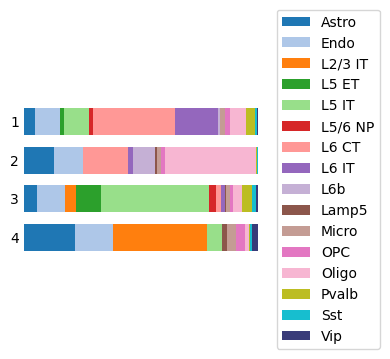

In [22]:
import seaborn as sns
from scipy.stats import kruskal

data = expenodf.copy()
data['Domain'] = domains  
df_grouped = data.groupby('Domain').sum()
df_normalized = df_grouped.div(df_grouped.sum(axis=1), axis=0)
filtered_palette = {k: color_dict[k] for k in df_normalized.columns if k in color_dict}

fig, ax = plt.subplots(figsize=(4, 3))
df_normalized.plot(kind='barh',  
                    stacked=True,
                    color=filtered_palette,
                    legend=False,
                    width=0.7,  
                    ax=ax)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='both', which='both', length=0)
plt.title('')
plt.xlabel('') 
plt.ylabel('')     
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.gca().invert_yaxis()
plt.xticks([])
plt.savefig('type_in_domain_l.pdf', 
            dpi=300, bbox_inches='tight')
plt.show()

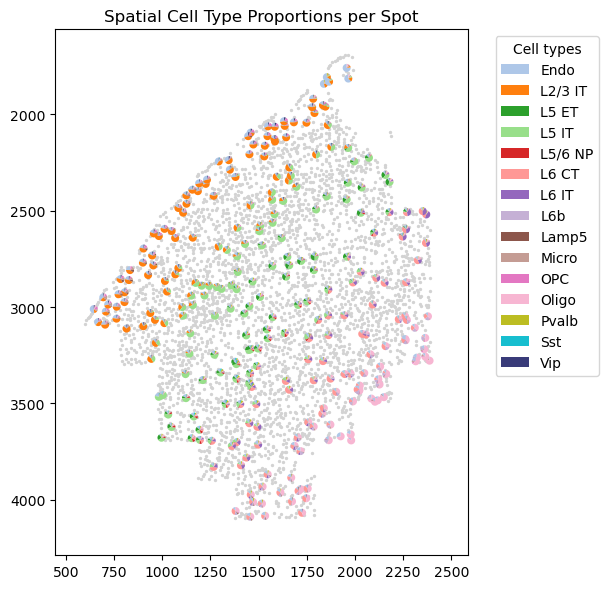

In [33]:
### scatter pie
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Patch
df = expeno.to_df()
df.drop(columns=[type_plot], inplace=True)
df = df.div(df.sum(axis=1), axis=0)
lassinde = np.setdiff1d(fish_loc.index.values, fish_locru.index.values)
fish_loc_usepass = fish_loc.loc[lassinde,:]
n = len(df.columns)
df = df.apply(lambda x: x/x.sum(), axis=1)
coords =fish_locru[['X','Y']].values #endecon.obsm['spatial']
proportions = df
filtered_palette = {k: color_dict[k] for k in df.columns if k in color_dict}
cell_types = proportions.columns.tolist()
pie_colors = [filtered_palette[cell_type] for cell_type in cell_types]


fig, ax = plt.subplots(figsize=(8, 6))
ax.set_aspect('equal')
ax.set_title("Spatial Cell Type Proportions per Spot")
colors = pie_colors
plt.scatter(fish_loc_usepass['X'],
            fish_loc_usepass['Y'], c='lightgray', s=2)
for i in range(coords.shape[0]):
    x, y = coords[i]
    fracs = proportions.iloc[i].values
    size = 1
    _ = inset_ax = inset_axes(ax, width=size, height=size, loc='center',
                              bbox_to_anchor=(x, y),
                              bbox_transform=ax.transData,
                              borderpad=0)
    _ = inset_ax.pie(fracs, colors=colors, startangle=90,
                     radius=0.1, wedgeprops=dict(edgecolor='white', linewidth=0.0001))#0.005
    _ = inset_ax.set_aspect("equal")
    _ = inset_ax.axis("off")
legend_elements = [Patch(facecolor=colors[i], label=cell_types[i]) for i in range(len(cell_types))]
ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', title="Cell types")
ax.set_ylim(coords[:,1].min()-200, coords[:,1].max()+200)
ax.set_xlim(coords[:,0].min()-200, coords[:,0].max()+200)
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('evo_pie_plot.pdf', dpi=900)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


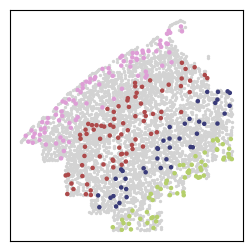

In [34]:
unique_clusters = np.unique(domains)
cluster_numeric = np.array([np.where(unique_clusters == i)[0][0] for i in domains])  
cmap = plt.get_cmap('tab20b', len(unique_clusters))
plt.figure(figsize=(3, 3))  
ax = plt.gca()
plt.scatter(fish_loc_usepass['X'], fish_loc_usepass['Y'], c='lightgray', s=2)
scpp = plt.scatter(fish_locru['X'], fish_locru['Y'], 
                  c=cluster_numeric, s=5, cmap=cmap)
plt.gca().invert_yaxis()
legend_elements = [plt.Line2D([0], [0], 
                           marker='o', 
                           color='w',
                           markersize=8,
                           markerfacecolor=cmap(i),
                           label=f'Domain {unique_clusters[i]}') 
                  for i in range(len(unique_clusters))]

legend = ax.legend(handles=legend_elements, 
                  loc='center left',
                  bbox_to_anchor=(1.02, 0.5),  
                  frameon=False,
                  title="Domains",
                  handletextpad=0.5,  
                  borderaxespad=0.)
plt.legend().remove()
plt.xticks([])
plt.yticks([])
plt.savefig('domain_in_loc.pdf', dpi=300, bbox_inches='tight')##
plt.show()

Identification of states.

In [16]:
sc.tl.rank_genes_groups(adataall, groupby="cell_types", method="t-test")

marker_type1 = sc.get.rank_genes_groups_df(adataall, group=type_plot)
p_value_threshold = 0.05
logfc_threshold =0.25
potential_markers1 = marker_type1[
    (marker_type1['pvals_adj'] < p_value_threshold) &
    (marker_type1['logfoldchanges'] > logfc_threshold)
]
hvg_genes1 = potential_markers1['names']
print(len(hvg_genes1))

print(len(np.intersect1d(fish_exp_raw.columns.values, hvg_genes1)))

5658
37


In [36]:
adataallthis = adataall[expenodf.index.values,hvg_genes1]
sc.pp.highly_variable_genes(adataallthis, n_top_genes=2000)
adataallthisvar = adataallthis[:, adataallthis.var['highly_variable']]
print(len(np.intersect1d(fish_exp_raw.columns.values, adataallthisvar.to_df().columns.values)))

37


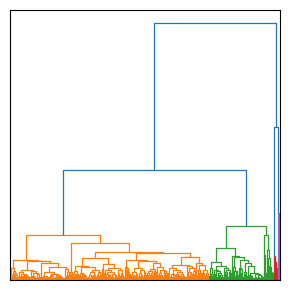

In [37]:
correlation_matrixclu = np.corrcoef(adataallthisvar.X)
distance_matrix = 1 - correlation_matrixclu
distance_matrix = (distance_matrix + distance_matrix.T) / 2  
np.fill_diagonal(distance_matrix, 0)
distance_matrix = pd.DataFrame(distance_matrix,
                               index =adataallthisvar.to_df().index.values,
                                columns=adataallthisvar.to_df().index.values)
linked = linkage(squareform(distance_matrix), method='ward')

desired_clusters = 4
clusters = fcluster(linked, t=desired_clusters, criterion='maxclust')
threshold = linked[-(desired_clusters-1), 2] 
plt.figure(figsize=(3, 3))
dendrogram(linked, labels=None, color_threshold=threshold)  
ax = plt.gca()
for line in ax.collections:  
    line.set_linewidth(0.9)
plt.title("")
plt.xticks([])
plt.yticks([])
plt.xlabel("")  
plt.ylabel("")
plt.tight_layout()  
plt.savefig('exp_cluster.pdf', dpi=300, bbox_inches='tight')##
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


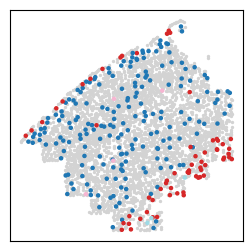

In [38]:
unique_clusters = np.unique(clusters)
cluster_numeric = np.array([np.where(unique_clusters == i)[0][0] for i in clusters])  
cmap = plt.get_cmap('tab20', len(unique_clusters))
plt.figure(figsize=(3, 3))  
ax = plt.gca()
plt.scatter(fish_loc_usepass['X'], fish_loc_usepass['Y'], c='lightgray', s=2)
scpp = plt.scatter(fish_locru['X'], fish_locru['Y'], 
                  c=cluster_numeric, s=5, cmap=cmap)
plt.gca().invert_yaxis()
legend_elements = [plt.Line2D([0], [0], 
                           marker='o', 
                           color='w',
                           markersize=8,
                           markerfacecolor=cmap(i),
                           label=f'State {unique_clusters[i]}') 
                  for i in range(len(unique_clusters))]

legend = ax.legend(handles=legend_elements, 
                  loc='center left',
                  bbox_to_anchor=(1.02, 0.5),  
                  frameon=False,
                  title="States",
                  handletextpad=0.5,  
                  borderaxespad=0.)
plt.legend().remove()
plt.xticks([])
plt.yticks([])
plt.savefig('state_in_loc.pdf', dpi=300, bbox_inches='tight')##
plt.show()

Enrichment and deletion between states and niches.

In [41]:
from scipy.stats import hypergeom
from matplotlib.lines import Line2D
from statsmodels.stats.multitest import multipletests
domain_labels = domains
state_labels = clusters
data = pd.DataFrame({"Niche": domain_labels, "State": state_labels})
domain_mapping = {
    1: 'niche1',
    2: 'niche2',
    3: 'niche3',
    4: 'niche4'
}
data["Niche"] = data["Niche"].map(domain_mapping)
state_mapping = {
    1: 'state1',
    2: 'state2',
    3: 'state3',
    4: 'state4'
}
data["State"] = data["State"].map(state_mapping)
unique_domains = data["Niche"].unique()
unique_states = data["State"].unique()

def plot_state_niche_pdf_dynamic(
    data: pd.DataFrame,
    niche_col: str = "Niche",
    state_col: str = "State",
    alpha: float = 0.05,                 
    sorted_states: list | None = None,   
    sorted_niches: list | None = None,  
    size_range: tuple = (20, 220),      
    figsize: tuple = (4, 3),
    fontsize: int = 12,
    output_pdf: str = "state_niche_enrich_deplete.pdf"
):
    df = data[[niche_col, state_col]].dropna().copy()
    ct = pd.crosstab(df[state_col], df[niche_col])
    states = ct.index.tolist()   if sorted_states  is None else list(sorted_states)
    niches = ct.columns.tolist() if sorted_niches is None else list(sorted_niches)
    ct = (ct.reindex(index=states, fill_value=0)
            .reindex(columns=niches, fill_value=0)).astype(int)
    X = ct.to_numpy(int)
    R, C = X.shape
    M = int(X.sum())
    K = X.sum(axis=1, keepdims=True)   
    N = X.sum(axis=0, keepdims=True)   
    p_enrich  = np.zeros_like(X, dtype=float)
    p_deplete = np.zeros_like(X, dtype=float)
    for i in range(R):
        Ki = int(K[i, 0])
        for j in range(C):
            Nj = int(N[0, j]); x = X[i, j]
            p_enrich[i, j]  = hypergeom.sf (x - 1, M, Ki, Nj)   # >= x
            p_deplete[i, j] = hypergeom.cdf(x,     M, Ki, Nj)   # <= x
    q_enrich  = np.zeros_like(p_enrich)
    q_deplete = np.zeros_like(p_deplete)
    for j in range(C):
        q_enrich[:, j]  = multipletests(p_enrich[:, j],  method="fdr_bh")[1]
        q_deplete[:, j] = multipletests(p_deplete[:, j], method="fdr_bh")[1]
    pts = []  
    for i in range(R):
        for j in range(C):
            qe, qd = q_enrich[i, j], q_deplete[i, j]
            if (qe <= alpha) or (qd <= alpha):
                if qe <= qd:
                    q  = max(qe, 1e-300); color = "red"  
                else:
                    q  = max(qd, 1e-300); color = "blue" 
                pts.append((j, i, color, -np.log10(q)))
    xs, ys, colors, sizes = [], [], [], []
    if pts:
        logqs = np.array([t[3] for t in pts], dtype=float)
        lmin, lmax = float(np.min(logqs)), float(np.max(logqs))
        smin, smax = size_range
        if lmax > lmin:
            sizes = [smin + (smax - smin) * (lq - lmin) / (lmax - lmin) for (_, _, _, lq) in pts]
        else:
            sizes = [0.5 * (smin + smax) for _ in pts]  
        xs = [t[0] for t in pts]; ys = [t[1] for t in pts]; colors = [t[2] for t in pts]
    plt.rcParams.update({"font.size": fontsize})
    fig, ax = plt.subplots(figsize=figsize)
    fig.patch.set_facecolor("white"); ax.set_facecolor("white")
    ax.set_xlim(-0.5, C - 0.5); ax.set_ylim(R - 0.5, -0.5)
    ax.set_xticks(range(C)); ax.set_xticklabels(niches, rotation=45, ha="right", fontsize=fontsize)
    ax.set_yticks(range(R)); ax.set_yticklabels(states, fontsize=fontsize)
    ax.set_xlabel("Niche", fontsize=fontsize); ax.set_ylabel("State", fontsize=fontsize)
    ax.set_title(f"Significant enrichment (red) / depletion (blue), FDR ≤ {alpha}", fontsize=fontsize)
    ax.grid(True, which="major", axis="both", linestyle="--", color="lightgray", linewidth=0.8)
    ax.set_axisbelow(True)
    if xs:
        sc = ax.scatter(xs, ys, s=sizes, c=colors, alpha=0.95,
                        edgecolors="black", linewidths=0.4, zorder=3, clip_on=True)
    color_handles = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='red',
               markeredgecolor='k', markersize=6, label='Enriched'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='blue',
               markeredgecolor='k', markersize=6, label='Depleted'),
    ]
    leg_color = ax.legend(
        handles=color_handles,
        loc="upper left",
        bbox_to_anchor=(1.02, 1.00),  
        borderaxespad=0.0,
        frameon=False,
        fontsize=fontsize,
        title="Direction"
    )
    ax.add_artist(leg_color)
    if pts:
        lvals = np.array([t[3] for t in pts], dtype=float)
        levels = np.unique(np.round([np.min(lvals), np.median(lvals), np.max(lvals)], 2))
        if len(levels) == 1:
            sizes_leg = [0.5 * (smin + smax)]
        else:
            sizes_leg = [smin + (smax - smin) * (lv - lmin) / (lmax - lmin) for lv in levels]
        size_handles = [plt.scatter([], [], s=s, facecolors='gray', edgecolors='k') for s in sizes_leg]
        size_labels  = [f"-log10(q) = {lv:g}" for lv in levels]
        leg_size = ax.legend(
            handles=size_handles,
            labels=size_labels,
            loc="upper left",
            bbox_to_anchor=(1.02, 0.45), 
            borderaxespad=0.0,
            frameon=False,
            fontsize=fontsize,
            title="−log10(q_adj)",
        )
        ax.add_artist(leg_size)
    plt.tight_layout()
    #fig.savefig(output_pdf, format="pdf", bbox_inches="tight", facecolor="white")
    plt.show()
    plt.close(fig)
    qE = pd.DataFrame(q_enrich,  index=states, columns=niches)
    qD = pd.DataFrame(q_deplete, index=states, columns=niches)
    return qE, qD, output_pdf

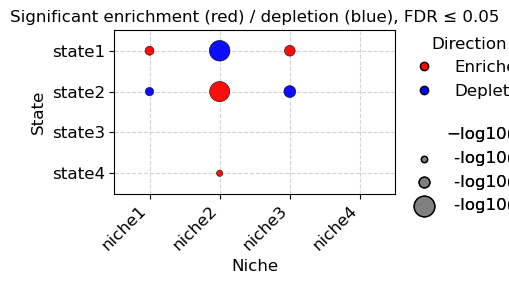

In [42]:
sorted_states = [f"state{i}" for i in range(1, 5)]
sorted_niches = [f"niche{i}" for i in range(1, 5)]
qE, qD, pdf_path = plot_state_niche_pdf_dynamic(
    data,
    sorted_states=sorted_states,
    sorted_niches=sorted_niches,
    alpha=0.05,
    size_range=(20, 220),
    figsize=(4, 3),
    fontsize=12,
    output_pdf="/state_niche_enrich_deplete.pdf"
)